In [16]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import string
from pathlib import Path
from collections import Counter
import json
import nltk
import requests
from datetime import datetime, timedelta


nltk.download("punkt")
nltk.download("stopwords")
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)

tf_idf = TfidfVectorizer(stop_words="english")


def encode_topics(df):
    # topics = df["topics"].str.get_dummies(sep=",")
    # topics = df["topics"].apply( topicfor topic in topics  )
    one_hot_encoded = (
        pd.get_dummies(df["topics"].apply(pd.Series).stack()).groupby(level=0).sum()
    )
    df = pd.concat([df, one_hot_encoded], axis=1)
    # print(df)
    return df


def set_index(df, index_column="poll_ID"):
    df.set_index(index_column, inplace=True)
    return df


def reset_index(df):
    df.reset_index()
    return df


def check_column_type(df, column_name, check_type):
    column_index = df.columns.get_loc(column_name)
    for i in range(len(df)):
        if not isinstance(df.iloc[i, column_index], check_type):
            print(
                f"error: {df.iloc[i, 0], df.iloc[i, 1],df.iloc[i, 2], df.iloc[i, 3], df.iloc[i, 4]}"
            )


def preprocess_text(text):
    tokens = nltk.tokenize.word_tokenize(text)
    # tokens = [word.lower() for word in tokens if type(word) is str]
    tokens = [word.lower() for word in tokens]
    tokens = [word for word in tokens if word not in string.punctuation]
    stop_words = set(nltk.corpus.stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]
    processed_text = " ".join(tokens)

    return processed_text


def preprocess_list(field_list):
    ret_list = []
    stop_words = set(nltk.corpus.stopwords.words("english"))
    for item in field_list:
        tokens = nltk.tokenize.word_tokenize(item)
        # tokens = [word.lower() for word in tokens if type(word) is str]
        tokens = [word.lower() for word in tokens]
        tokens = [word for word in tokens if word not in string.punctuation]
        tokens = [word for word in tokens if word not in stop_words]
        processed_text = " ".join(tokens)
        ret_list.append(processed_text)

    return ret_list


def create_tf_idf_matrix(df, column):
    # print(f"{df[column]} is {df[column].dtype} and {df[column].dtype is list} {list}: ")
    df[column] = df[column].apply(lambda x: " ".join(x))
    df[column] = df[column].apply(preprocess_text)

    return tf_idf.fit_transform(df[column])


def create_souped_tf_idf_matrix(df):
    df["topics"] = df["topics"].apply(preprocess_list)
    df["question"] = df["question"].apply(preprocess_text)

    # Create a new soup feature
    df["soup"] = df.apply(create_soup, axis=1)

    return tf_idf.fit_transform(df["soup"])


def create_soup(df):
    res = (
        df["question"]
        + " "
        + " ".join(df["options"])
        + " "
        + (4 * (" " + " ".join(df["topics"])))
    )
    # print(f"-----------------------------------\n* Processing: [{ }]")
    return res


def calc_cosine_similarity_matrix(tf_idf_matrix_1, tf_idf_matrix_2):
    # if tf_idf_matrix_1 is not None and tf_idf_matrix_2 is not None:
    return cosine_similarity(tf_idf_matrix_1, tf_idf_matrix_2)


def id_to_index(df, search_id):
    result = df[df["id"] == str(search_id)].index.values[0]
    print(result)

    if len(result) > 0:
        return result
    else:
        return None


def id_to_index2(df, id):
    try:
        if any(df["id"] == str(id)):
            # df.to_csv("df.csv", index=False)
            # print(
            #    f"---------------\nFound {id} at {df[df['id'] == str(id)].index.values[0]}"
            # )
            # print(f"\nWhich is equal to:\n{df[df['id'] == str(id)]}")
            return df[df["id"] == str(id)].index.values[0]

    except IndexError as e:
        print(f"erorrrrrrrrrrrrr:")
        print(f"{str(id)}")
        print(f"{df['id']==str(id)}")


def title_from_idx(df, idx):
    return df[df.index == idx]


def gen_recommendations(
    index,
    df,
    cosine_similarity_matrix,
    number_of_recommendations,
):
    # index = idx_from_title(df, original_title)
    similarity_scores = list(enumerate(cosine_similarity_matrix[index]))
    similarity_scores_sorted = sorted(
        similarity_scores, key=lambda x: x[1], reverse=True
    )

    recommendations_indices = [
        t[0] for t in similarity_scores_sorted[1 : (number_of_recommendations + 1)]
    ]
    recommendations = list(df["title"].iloc[recommendations_indices])
    # print(recommendations)
    # print(similarity_scores_sorted, type(similarity_scores_sorted))
    # recommendations_indices = [
    #    t[0] for t in similarity_scores_sorted[1 : (number_of_recommendations + 1)]
    # ]
    # recommendations_scores = [
    #    t[1] for t in similarity_scores_sorted[1 : (number_of_recommendations + 1)]
    # ]
    # return (df["title"].iloc[recommendations_indices], recommendations_scores)

    return recommendations


def gen_rec_from_list_of_polls(
    interacted_polls,
    filtered_polls_df,
    cosine_similarity_matrix,
    number_of_recommendations,
):
    recommendations = []
    for poll_id in interacted_polls:
        index = id_to_index2(filtered_polls_df, poll_id)
        if index is not None:
            similarity_scores = list(enumerate(cosine_similarity_matrix[index]))
            similarity_scores_sorted = sorted(
                similarity_scores, key=lambda x: x[1], reverse=True
            )

            recommendations_indices = [
                t[0]
                for t in similarity_scores_sorted[1 : (number_of_recommendations + 1)]
            ]
            recs = list(filtered_polls_df["id"].iloc[recommendations_indices])

            # Filter out polls that have already been interacted with
            filtered_recs = [poll for poll in recs if poll not in interacted_polls]

            recommendations.append(filtered_recs)

        else:
            pass

        # index = id_to_index(polls, poll_id)
        # print(f"cosine_similarity_matrix:{len(cosine_similarity_matrix)}")
        # print(f"index:{index} | id:{poll_id}")

    flattened_recommendations = [
        item for sublist in recommendations for item in sublist
    ]
    flattened_recommendations = Counter(flattened_recommendations)
    n_most_recommended = flattened_recommendations.most_common(
        number_of_recommendations
    )
    n_most_recommended = [t[0] for t in n_most_recommended]
    # print(n_most_recommended)

    return n_most_recommended


def gen_rec_from_list_of_polls_df(
    interacted_polls,
    filtered_polls_df,
    cosine_similarity_matrix,
    number_of_recommendations,
):
    recommendations = []
    for poll_id in interacted_polls:
        index = id_to_index2(filtered_polls_df, poll_id)
        if index is not None:
            similarity_scores = list(enumerate(cosine_similarity_matrix[index]))
            similarity_scores_sorted = sorted(
                similarity_scores, key=lambda x: x[1], reverse=True
            )

            recommendations_indices = [
                t[0]
                for t in similarity_scores_sorted[1 : (number_of_recommendations + 1)]
            ]
            recs = list(filtered_polls_df["id"].iloc[recommendations_indices])

            # Filter out polls that have already been interacted with
            filtered_recs = [poll for poll in recs if poll not in interacted_polls]

            recommendations.append(filtered_recs)

        else:
            pass

        # index = id_to_index(polls, poll_id)
        # print(f"cosine_similarity_matrix:{len(cosine_similarity_matrix)}")
        # print(f"index:{index} | id:{poll_id}")

    flattened_recommendations = [
        item for sublist in recommendations for item in sublist
    ]
    flattened_recommendations = Counter(flattened_recommendations)
    n_most_recommended = flattened_recommendations.most_common(
        number_of_recommendations
    )
    n_most_recommended = [t[0] for t in n_most_recommended]

    filtered_df = filtered_polls_df[filtered_polls_df["id"].isin(n_most_recommended)]

    order_dict = {id: idx for idx, id in enumerate(n_most_recommended)}

    # Sort the filtered DataFrame based on the order
    filtered_df["order"] = filtered_df["id"].map(order_dict)
    filtered_df = filtered_df.sort_values("order")

    # Drop the 'order' column if not needed
    filtered_df = filtered_df.drop(columns=["order"])

    # Reset the index if needed
    filtered_df = filtered_df.reset_index(drop=True)

    return filtered_df


def is_valid_limitations(limitations):
    if isinstance(limitations, dict):
        return (
            "allowedLocations" in limitations
            and "allowedGender" in limitations
            and "allowedAgeRange" in limitations
        )
    return False


def is_within_10_days_liifetime(timestamp):
    try:
        # Convert the timestamp to a datetime object
        time = datetime.strptime(timestamp, "%Y-%m-%dT%H:%M:%S.%fZ")

        # Calculate the time difference
        time_difference = datetime.now() - time

        return True if time_difference <= timedelta(days=10) else False
    except ValueError:
        # If the timestamp doesn't match the expected format, return False
        return False


def has_valid_date(date_str):
    # Convert the date string to a datetime object
    # date = pd.to_datetime(date_str)
    date = pd.to_datetime(date_str, utc=True).replace(tzinfo=None)

    # Get the current timestamp as a datetime object
    current_time = datetime.now()

    # Compare the date with the current timestamp
    return date > current_time


def remove_duplicates(input_list):
    seen = set()
    result = []

    for item in input_list:
        if item not in seen:
            seen.add(item)
            result.append(item)

    return result


def validate_polls(polls_df, df_name, verbose=True):
    valid_polls = polls_df.loc[
        polls_df["valid"] & polls_df["endedAt"].apply(has_valid_date)
    ]

    invalid_polls = polls_df[
        ~polls_df["valid"] | ~polls_df["endedAt"].apply(has_valid_date)
    ]

    if verbose:
        print(f"valid_{df_name}_polls: {len(valid_polls)}")
        print(f"expired_{df_name}_polls: {len(invalid_polls)}")

    return valid_polls, invalid_polls
    return pd.concat([valid_polls, invalid_polls], ignore_index=False)


def order(recommended_polls_df=None, trend_polls_df=None, verbose=True):
    if recommended_polls_df is None:
        valid_trend_polls, invalid_trend_polls = validate_polls(
            trend_polls_df, "trend", verbose
        )
        recommended_polls_df = pd.concat(
            [
                valid_trend_polls,
                invalid_trend_polls,
            ],
            ignore_index=False,
        )

    elif trend_polls_df is None:
        valid_recommended_polls, invalid_recommended_polls = validate_polls(
            recommended_polls_df, "recommended", verbose
        )
        recommended_polls_df = pd.concat(
            [
                valid_recommended_polls,
                invalid_recommended_polls,
            ],
            ignore_index=False,
        )

    elif trend_polls_df is not None and recommended_polls_df is not None:
        valid_recommended_polls, invalid_recommended_polls = validate_polls(
            recommended_polls_df, "recommended", verbose
        )
        valid_trend_polls, invalid_trend_polls = validate_polls(
            trend_polls_df, "trend", verbose
        )

        recommended_polls_df = pd.concat(
            [
                valid_recommended_polls,
                valid_trend_polls,
                invalid_recommended_polls,
                invalid_trend_polls,
            ],
            ignore_index=False,
        )

    recommended_polls_df = recommended_polls_df.reset_index(drop=True)
    recommended_polls_df = recommended_polls_df["id"].tolist()
    recommended_polls_df = remove_duplicates(recommended_polls_df)

    return recommended_polls_df


def filter_timestamp(timestamp):
    try:
        # Convert the timestamp to a datetime object
        time = datetime.strptime(timestamp, "%Y-%m-%dT%H:%M:%S.%fZ")

        # Calculate the time difference
        time_difference = datetime.now() - time

        return time_difference
    except ValueError:
        # If the timestamp doesn't match the expected format, return None
        return None


def split_df_by_lifetime(polls_df):
    filtered_df = polls_df[polls_df["createdAt"].apply(filter_timestamp).notna()]

    older_than_10_days = filtered_df[
        filtered_df["createdAt"].apply(filter_timestamp) >= timedelta(days=10)
    ]
    newer_than_10_days = filtered_df[
        filtered_df["createdAt"].apply(filter_timestamp) < timedelta(days=10)
    ]

    # Reset the index if needed
    older_than_10_days = older_than_10_days.reset_index(drop=True)
    newer_than_10_days = newer_than_10_days.reset_index(drop=True)

    return older_than_10_days, newer_than_10_days


def list_to_df(polls_list, polls_df):
    # Filter the DataFrame based on the id_list
    filtered_df = polls_df[polls_df["id"].isin(polls_list)]

    # Create a dictionary to preserve the order
    order_dict = {id: idx for idx, id in enumerate(polls_list)}

    # Sort the filtered DataFrame based on the order
    filtered_df["order"] = filtered_df["id"].map(order_dict)
    filtered_df = filtered_df.sort_values("order")

    # Drop the 'order' column if not needed
    filtered_df = filtered_df.drop(columns=["order"])

    # Reset the index if needed
    filtered_df = filtered_df.reset_index(drop=True)
    return filtered_df


def filter_polls(row, user_limitations):
    if (
        row["pollType"] == "Public"
        and isinstance(row.get("pollLimitations"), dict)
        and all(k in user_limitations for k in ["Location", "Gender", "Age"])
        # and is_within_10_days_liifetime(row["createdAt"])
    ):
        user_location = user_limitations.get("Location")

        allowed_locations = row.get("pollLimitations").get("allowedLocations")
        if len(allowed_locations) == 0 or any(
            user_location == loc for loc in allowed_locations
        ):
            allowed_gender = row["pollLimitations"]["allowedGender"]
            user_gender = user_limitations["Gender"]
            if allowed_gender == "All" or allowed_gender == user_gender:
                allowed_age_range = row["pollLimitations"]["allowedAgeRange"]
                user_age = user_limitations["Age"]
                if (
                    allowed_age_range["minimumAge"]
                    <= user_age
                    <= allowed_age_range["maximumAge"]
                ):
                    return True

    return False


def get_allowed_private_polls(
    params,
    url="https://dev.pollett.io/api/Recommend/Polls/GetPrivatePollThatUserCanSee",
):
    # API URL
    # url = "https://dev.pollett.io/api/Recommend/Polls/GetPrivatePollThatUserCanSee"

    # Parameters
    # params = {"userId": "bbe64b34-ba34-4fbd-a62f-e6c84c0423b4"}

    # Send a GET request to the API
    response = requests.get(url, params=params)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Parse the JSON response
        # allowed_polls_list = response.json().get("data")
        return response.json().get("data")
        # Process the data as needed

    else:
        # Handle the error
        print(f"Request failed with status code {response.status_code}")
        print(response.text)

[nltk_data] Downloading package punkt to /home/eyz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/eyz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
from elasticsearch import Elasticsearch
import json


class ElasticsearchHandel:
    def __init__(self, elasticsearch_url, username, password, fingerprint):
        self.elasticsearch_url = elasticsearch_url
        self.username = username
        self.password = password
        self.fingerprint = fingerprint
        self.client = Elasticsearch(
            hosts=self.elasticsearch_url,
            basic_auth=(self.username, self.password),
            ssl_assert_fingerprint=self.fingerprint,
        )

    def get_index(self, index_name, batch_size=100):
        setattr(self, index_name, [])
        index_list = getattr(self, index_name)
        from_index = 0
        all_instances = []

        while True:
            # query = {"query": {"match_all": {}}, "size": batch_size, "from": from_index}
            results = self.client.search(
                index=index_name,
                query={"match_all": {}},
                size=batch_size,
                from_=from_index,
            )
            instances = results["hits"]["hits"]

            all_instances.extend(instances)
            from_index += batch_size
            if len(instances) < 100:
                break

        setattr(self, index_name, [instance["_source"] for instance in all_instances])
        return getattr(self, index_name)

    def get_interactions(self, index_name, user_id, batch_size=100):
        # setattr(self, index_name, [])
        # index_list = getattr(self, index_name)
        from_index = 0
        all_instances = []

        query = {
            "match_phrase": {"userId": user_id},
        }

        results = self.client.search(
            index=index_name,
            query=query,
            size=batch_size,
            from_=from_index,
            timeout="1s",
        )
        # instances = results["hits"]["hits"][0]
        hits = results["hits"].get("hits")

        if not hits:
            # raise ValueError("User doesn't have any interactions.")
            raise InteractionNotFound()

        return hits[0].get("_source")

    def get_trend_polls(self, polls):
        # polls = getattr(self, "polls")
        # trend_polls = sorted(polls, key=lambda x: (-x["numberOfPollups"], -x["numberOfVotes"], -x["numberOfLike"]))
        trend_polls = sorted(
            polls,
            key=lambda x: (
                -x["numberOfVotes"],
                -x["numberOfLike"],
                # -x["numberOfPollUp"],
            ),
        )

        # recs = trend_polls["id"]

        # print("\n", filtered_trend_polls, "\n")
        # setattr(self, "trend_polls", trend_polls)
        return trend_polls

    def export_index_to_file(self, index, index_file_path):
        try:
            with open(index_file_path, "w") as output:
                # for instance in self.instances:
                #        json.dump(instance["_source"], output, indent=4)
                json.dump(index, output, indent=4)
        except Exception as exp:
            print("Export Error", exp)

In [9]:
import pandas as pd

elasticsearch_url = "https://159.203.183.251:9200"
username = "pollett"
password = "9r0&rJP@19GY"
fingerprint = "CE:AA:F7:FF:04:C7:31:14:78:9C:62:D4:CE:98:F9:EF:56:DA:70:45:37:14:E3:F8:66:0A:25:ED:05:04:83:ec"


elastic_handle = ElasticsearchHandel(elasticsearch_url, username, password, fingerprint)

polls = elastic_handle.get_index("polls")
trend_polls = elastic_handle.get_trend_polls(polls)

polls_df = pd.DataFrame.from_records(polls)

polls_df

,id,question,options,topics,pollType,ownerId,createdAt,numberOfLike,numberOfViews,numberOfVotes,numberOfComments,numberOfPollUp,isDeleted,pollLimitations,enedAt,status,valid,endedAt,isActive
0,00caf3ec-d71c-4993-9791-9a0f7d17d445,When it comes to scientific research on physic...,[Studying the impact of urban planning on phys...,"[Activity, Science]",Public,f913b927-d5b6-4f26-ab81-692800abe10d,2023-09-28T09:52:15.045352Z,0,0,0,0,0,False,"{'allowedLocations': [], 'allowedGender': 'All...",2023-11-22T09:52:15.048545Z,Live,True,2023-11-22T09:52:15.048545Z,NaN
1,006367ff-ab22-4771-b6ab-98a8d247ca3f,Should genetically modified organisms (GMOs) b...,"[No labeling required, Yes, mandatory labeling...","[Science, Politics]",Public,f913b927-d5b6-4f26-ab81-692800abe10d,2023-09-28T09:52:15.045375Z,0,0,0,0,0,False,"{'allowedLocations': [], 'allowedGender': 'All...",2023-11-22T09:52:15.048545Z,Live,True,2023-11-22T09:52:15.048545Z,NaN
2,00763b59-dbdf-47fa-80a5-ec844bf28279,"In your opinion, does the art market provide e...","[No, Yes]","[Art, Economy]",Public,ba8e1221-990b-432a-b5ed-61b937b623dd,2023-09-28T09:52:15.051198Z,0,7,2,1,1,False,"{'allowedLocations': [], 'allowedGender': 'All...",2023-11-22T09:52:15.048545Z,Live,True,2023-11-22T09:52:15.048545Z,NaN
3,00093e03-da86-498a-8950-5eafcc52b7f6,How much are you willing to spend on a single ...,"[$10 - $50, $50 - $100, Less than $10, More th...","[Beauty, Economy]",Public,677256ef-8222-4e37-8777-ed616a3dbc37,2023-09-28T09:52:15.043075Z,0,0,0,0,0,False,"{'allowedLocations': [], 'allowedGender': 'All...",2023-11-22T09:52:15.048545Z,Live,True,2023-11-22T09:52:15.048545Z,NaN
4,0010ca42-d86d-45b9-b85c-61c1db89b7c6,Do you want to live in another country?,"[No, Yes]",[General],Public,e00b366a-37a8-407d-9a15-e585d1ad539a,2023-08-06T14:16:47.828393Z,3,14,1,19,0,False,"{'allowedLocations': [], 'allowedGender': 'All...",2023-08-16T14:16:46.838Z,Ended,False,2023-08-16T14:16:46.838Z,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006,de4e998c-fd9d-449d-80d4-aff81448b7ff,test,"[1, 3]",[General],Public,67eb27ca-ba0b-4d29-8627-9ec78327b512,2023-11-28T12:42:34.9288344Z,0,0,1,0,0,False,"{'allowedLocations': [], 'allowedGender': 'All...",NaN,NaN,True,2023-12-08T12:42:34.403Z,NaN
2007,9dec9129-ffde-43be-a377-ec89f5a7f9a1,test,"[1, 2]",[General],Public,67eb27ca-ba0b-4d29-8627-9ec78327b512,2023-11-28T13:05:01.5399629Z,0,0,1,0,0,False,"{'allowedLocations': [], 'allowedGender': 'All...",NaN,NaN,True,2023-12-08T13:05:01.143Z,NaN
2008,857b92af-e66d-4c88-ad21-5bde48e3a0de,te,"[1, 12]",[General],Public,67eb27ca-ba0b-4d29-8627-9ec78327b512,2023-11-28T12:59:16.8046804Z,0,0,1,0,0,False,"{'allowedLocations': [], 'allowedGender': 'All...",NaN,NaN,True,2023-12-08T12:59:16.389Z,NaN
2009,ce6aa9ec-224a-46db-b815-4efa79982bed,a,"[q, d]",[General],Public,67eb27ca-ba0b-4d29-8627-9ec78327b512,2023-11-28T12:53:47.2303019Z,0,0,1,0,0,False,"{'allowedLocations': [], 'allowedGender': 'All...",NaN,NaN,True,2023-12-08T12:53:46.714Z,NaN


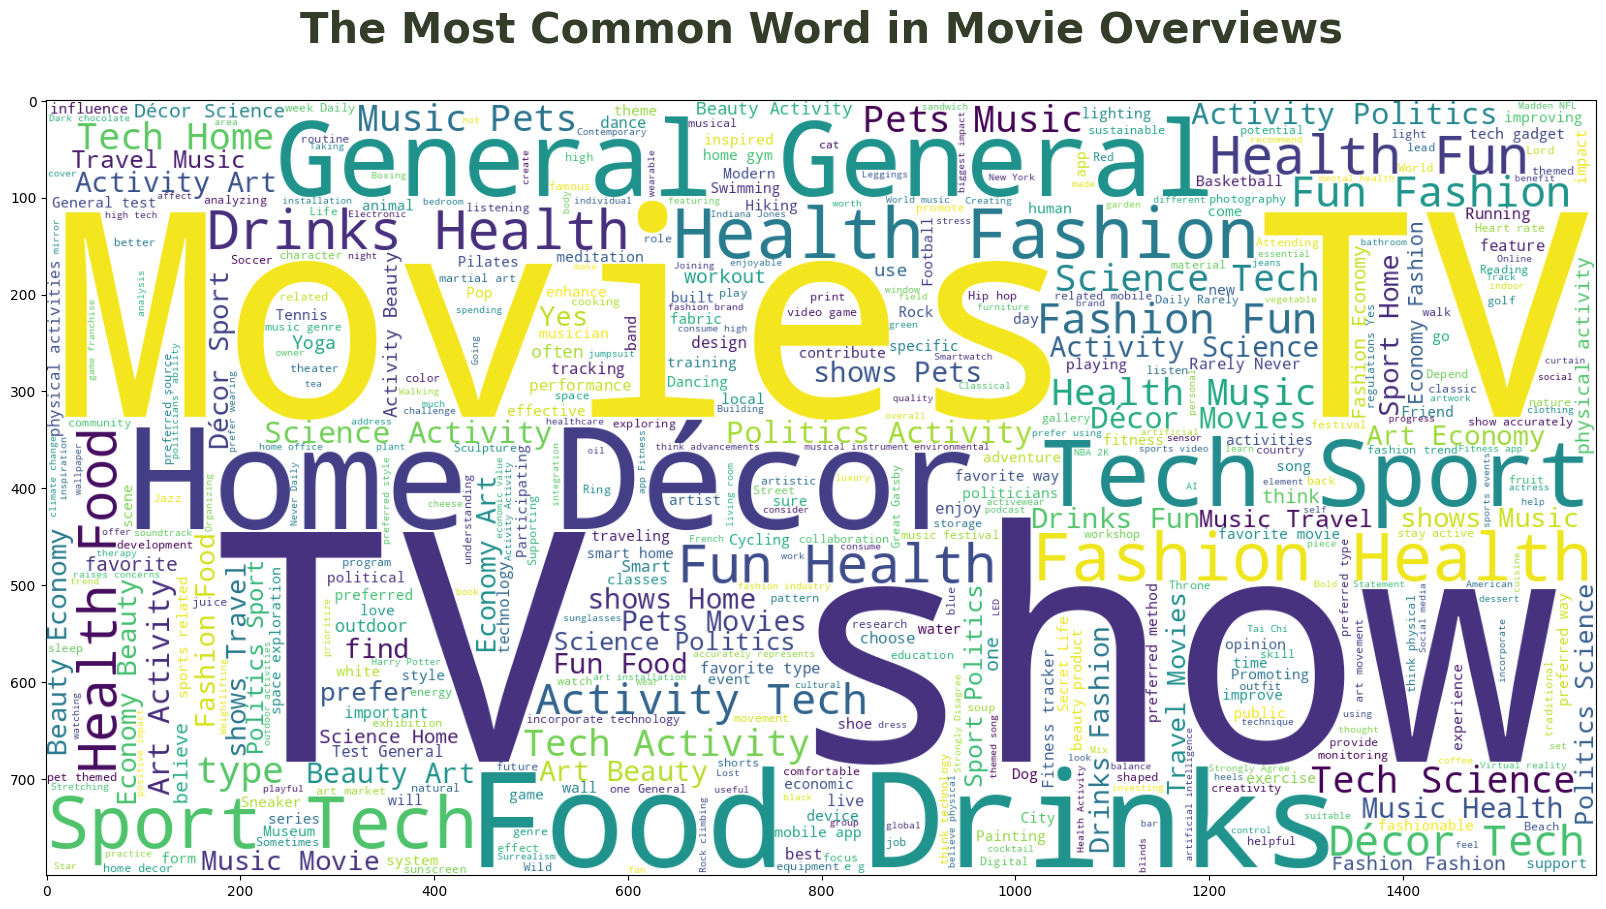

In [23]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

temp_df["soup"] = polls_df.apply(create_soup, axis=1)


plt.figure(figsize=(20, 20))
plt.title(
    "The Most Common Word in Movie Overviews\n",
    fontsize=30,
    weight=600,
    color="#333d29",
)
wc = WordCloud(
    max_words=1000, min_font_size=10, height=800, width=1600, background_color="white"
).generate(" ".join(temp_df["soup"]))

plt.imshow(wc)

In [4]:
test_limitations = {
    "allowedLocations": [
        {"country": "United States", "city": "United States", "state": "NJ"},
        {"country": "United States", "city": "United States", "state": "NJ"},
        {"country": "United States", "city": "United States", "state": "NJ"},
    ],
    "allowedGender": "All",
    "allowedAgeRange": {"minimumAge": 0, "maximumAge": 120},
    "isDeleted": False,
}

constraint_parameters = {
    "Location": {"country": "United States", "city": "United States", "state": "NJ"},
    "Gender": "Men",
    "Age": 30,
}

In [5]:
filtered_polls_df = polls_df[
    polls_df.apply(filter_polls, args=(constraint_parameters,), axis=1)
]
user_id = "e00b366a-37a8-407d-9a15-e585d1ad539a"
user_id = "61400ff7-531a-425e-a506-e2a900eec613"
user_id = "67eb27ca-ba0b-4d29-8627-9ec78327b512"
# filtered_polls_df = filtered_polls_df.reset_index(drop=True)
allowed_polls_list = get_allowed_private_polls(
    # params={"userId": "bbe64b34-ba34-4fbd-a62f-e6c84c0423b4"}
    params={"userId": user_id}
)
allowed_private_polls = polls_df[polls_df["id"].isin(allowed_polls_list)]
allowed_private_polls = allowed_private_polls[
    allowed_private_polls.apply(filter_polls, args=(constraint_parameters,), axis=1)
]

concatenated_df = pd.concat([filtered_polls_df, allowed_private_polls], axis=0)
# Reset the index if needed
concatenated_df.reset_index(drop=True, inplace=True)

In [11]:
concatenated_df.loc[concatenated_df["id"] == "00763b59-dbdf-47fa-80a5-ec844bf28279"]

,id,question,options,topics,pollType,ownerId,createdAt,numberOfLike,numberOfViews,numberOfVotes,numberOfComments,numberOfPollUp,isDeleted,pollLimitations,enedAt,status,valid,endedAt,isActive
2,00763b59-dbdf-47fa-80a5-ec844bf28279,"In your opinion, does the art market provide equal economic opportunities for artists from diverse backgrounds?","[No, Yes]","[Art, Economy]",Public,ba8e1221-990b-432a-b5ed-61b937b623dd,2023-09-28T09:52:15.051198Z,0,7,2,1,1,False,"{'allowedLocations': [], 'allowedGender': 'All', 'allowedAgeRange': {'minimumAge': 0, 'maximumAge': 120}}",2023-11-22T09:52:15.048545Z,Live,True,2023-11-22T09:52:15.048545Z,NaN


In [31]:
polls_tf_idf_matrix = create_souped_tf_idf_matrix(concatenated_df)

In [32]:
trend_polls = elastic_handle.get_trend_polls(polls)
trend_polls_df = pd.DataFrame.from_records(trend_polls)
filtered_trend_polls_df = trend_polls_df[
    trend_polls_df.apply(filter_polls, args=(constraint_parameters,), axis=1)
]
filtered_trend_polls_df = filtered_trend_polls_df.reset_index(drop=True)
filtered_trend_polls_list = filtered_trend_polls_df["id"].tolist()

In [33]:
print(f"filtered_trend_polls_list: {type(filtered_trend_polls_list)}")
print(f"filtered_trend_polls_list: {len(filtered_trend_polls_list)}")

filtered_trend_polls_list: <class 'list'>
filtered_trend_polls_list: 1937


In [34]:
filtered_polls_df = concatenated_df[["id", "createdAt", "endedAt", "valid"]]

In [35]:
filtered_polls_df

,id,createdAt,endedAt,valid
0,00caf3ec-d71c-4993-9791-9a0f7d17d445,2023-09-28T09:52:15.045352Z,2023-11-22T09:52:15.048545Z,True
1,006367ff-ab22-4771-b6ab-98a8d247ca3f,2023-09-28T09:52:15.045375Z,2023-11-22T09:52:15.048545Z,True
2,00763b59-dbdf-47fa-80a5-ec844bf28279,2023-09-28T09:52:15.051198Z,2023-11-22T09:52:15.048545Z,True
3,00093e03-da86-498a-8950-5eafcc52b7f6,2023-09-28T09:52:15.043075Z,2023-11-22T09:52:15.048545Z,True
4,0010ca42-d86d-45b9-b85c-61c1db89b7c6,2023-08-06T14:16:47.828393Z,2023-08-16T14:16:46.838Z,False
...,...,...,...,...
1932,ffc775ab-6034-4454-9ddc-ca3b032a64a8,2023-09-28T09:52:15.045845Z,2023-11-22T09:52:15.048545Z,True
1933,ff9898ea-8275-45ae-a6d8-96a1075ead1a,2023-09-28T09:52:15.043684Z,2023-11-22T09:52:15.048545Z,True
1934,fff702c2-fe64-46ff-b62d-757a8ca87e32,2023-09-28T09:52:15.043532Z,2023-11-22T09:52:15.048545Z,True
1935,ff77be43-bb90-460b-b5b5-a62ed5108b40,2023-09-28T09:52:15.044387Z,2023-11-22T09:52:15.048545Z,True


In [36]:
cosine_similarity_matrix = calc_cosine_similarity_matrix(
    polls_tf_idf_matrix, polls_tf_idf_matrix
)

In [37]:
userInteractions = elastic_handle.get_interactions("userpollinteractions", user_id)

userInteractions = [
    interaction["pollId"] for interaction in userInteractions["userPollActions"][:20]
]

In [42]:
recommended_polls_df = gen_rec_from_list_of_polls_df(
    interacted_polls=userInteractions,
    filtered_polls_df=filtered_polls_df,
    cosine_similarity_matrix=cosine_similarity_matrix,
    number_of_recommendations=100,
)

/tmp/ipykernel_22472/3213173550.py:265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["order"] = filtered_df["id"].map(order_dict)


In [46]:
recommended_polls_df

,id,createdAt,endedAt,valid
0,fe006616-669b-411c-9b39-fba5092fa422,2023-09-28T09:52:15.042845Z,2023-11-22T09:52:15.048545Z,True
1,07ad28ae-3eac-44bb-a28a-e61ed937cfa5,2023-09-28T09:52:15.04293Z,2023-11-22T09:52:15.048545Z,True
2,f4860da8-9f3b-434a-a9e4-57fe1d14240f,2023-09-28T09:52:15.04301Z,2023-11-22T09:52:15.048545Z,True
3,5348b63d-b524-4fe0-b9fd-6eecdebd1c7e,2023-09-28T09:52:15.04289Z,2023-11-22T09:52:15.048545Z,True
4,6c17d6e8-534b-4432-8ae3-3583f5baa632,2023-09-28T09:52:15.046306Z,2023-11-22T09:52:15.048545Z,True
...,...,...,...,...
95,498f4a76-152e-4893-a758-970bcc8aca94,2023-09-28T09:52:15.043054Z,2023-11-22T09:52:15.048545Z,True
96,fb3c874d-0472-476e-9b7e-46194d1735e6,2023-09-28T09:52:15.042882Z,2023-11-22T09:52:15.048545Z,True
97,62306fca-ab83-4baa-828c-9780dd037f00,2023-09-28T09:52:15.043007Z,2023-11-22T09:52:15.048545Z,True
98,bb7c6266-e514-4fd4-b84e-91b94d01438c,2023-09-28T09:52:15.043028Z,2023-11-22T09:52:15.048545Z,True


In [47]:
trend_polls_df = list_to_df(filtered_trend_polls_list, filtered_polls_df)

In [50]:
recommended_polls_list = order(
    recommended_polls_df,
    trend_polls_df,
)

trend_polls_df_valid_polls: 1792
trend_polls_df_expired_polls: 145
recommended_polls_df_valid_polls: 98
recommended_polls_df_expired_polls: 2


In [49]:
recommended_polls_list

['fe006616-669b-411c-9b39-fba5092fa422',
 '07ad28ae-3eac-44bb-a28a-e61ed937cfa5',
 'f4860da8-9f3b-434a-a9e4-57fe1d14240f',
 '5348b63d-b524-4fe0-b9fd-6eecdebd1c7e',
 '6c17d6e8-534b-4432-8ae3-3583f5baa632',
 '62a031df-9283-4eee-88f2-ce806e650bdb',
 '349c0fd7-d326-419d-8e8d-721cdd141ff3',
 'c6fc5bee-1c6e-4ea9-8493-ae5b88c12523',
 '707ac681-dd55-411a-9b32-73cf283d795c',
 '15a16fb2-474a-4462-bd5f-7009807a6968',
 'dd74fedb-aee2-4113-9d74-38151f3318b9',
 'c42d93f3-ef77-440b-bc18-7942b83eda49',
 '01e94829-53ea-477e-b806-4956cc67a02a',
 '7508aa13-514a-4c0a-b8cf-92fcce97c672',
 '7d8673c7-2b98-48f2-8a8c-4bd2f11a1bfd',
 '9d877762-e63e-41b2-9f09-69c531e84d28',
 '96d01671-7c92-4795-8621-18bb49afeb79',
 '19475b13-504e-4650-bf53-487d7b718ca7',
 'a408f381-d6e1-4b50-91c5-97d3027ce902',
 '23dd304a-e65f-4efd-870d-56b6319d0153',
 '690ff319-27cc-498c-bad0-3fc0f84634b4',
 'a82fd0f8-47a6-469e-b95d-4f5ed9797913',
 '8327c73e-dc7e-4f59-983e-ea2da1dce663',
 '6d269392-f854-49e7-b781-e933b6e6e59a',
 '3181625b-aa5b-

In [30]:
expired_trend_polls, valid_trend_polls = split_df_by_lifetime(trend_polls_df)

In [31]:
recommended_polls_list = pd.concat(
    [
        valid_recommended_polls,
        valid_trend_polls,
        expired_recommended_polls,
        expired_trend_polls,
    ],
    ignore_index=False,
)

In [32]:
recommended_polls_list

,id,createdAt,endedAt
0,e3303719-bcae-455a-a7c2-fd29c17e6216,2023-10-30T07:56:05.744197Z,2023-11-09T07:56:06.318Z
1,6c9877b7-6607-456e-8bd5-d1aaf6d5b784,2023-10-31T05:34:34.716433Z,2023-11-10T05:34:34.478Z
2,a5d4f74a-7bc1-4dad-940f-1f471d377e96,2023-10-31T06:41:43.748954Z,2023-11-10T06:41:43.626Z
3,c75ba776-49f5-4862-adf7-a879ff4f3df2,2023-10-30T07:56:59.96682Z,2023-10-31T05:29:29.083378Z
4,7a3670b9-4824-4a55-ad12-ba07cb7b588d,2023-10-30T07:56:48.941826Z,2023-11-09T07:56:49.519Z
...,...,...,...
1944,f347c855-50c4-4f70-864b-bd994039afb3,2023-09-28T09:52:15.045344Z,2023-10-30T09:52:15.048545Z
1945,f34c6ec9-59ce-4180-aa84-0eb6956a27cc,2023-09-28T09:52:15.044215Z,2023-10-30T09:52:15.048545Z
1946,f39bdec3-8ba4-450f-b0fa-f235b87b3820,2023-09-28T09:52:15.049067Z,2023-10-30T09:52:15.048545Z
1947,f3c0981f-9906-4b19-a093-69f4a7eebc74,2023-09-28T09:52:15.043282Z,2023-10-30T09:52:15.048545Z


In [33]:
print(f"valid_recommended_polls length:{len(valid_recommended_polls)}")
print(f"valid_trend_polls length:{len(valid_trend_polls)}")
print(f"expired_recommended_polls length:{len(expired_recommended_polls)}")
print(f"expired_trend_polls length:{len(expired_trend_polls)}")

valid_recommended_polls length:0
valid_trend_polls length:7
expired_recommended_polls length:100
expired_trend_polls length:1949


In [34]:
def remove_duplicates(input_list):
    seen = set()
    result = []

    for item in input_list:
        if item not in seen:
            seen.add(item)
            result.append(item)

    return result


recommended_polls_list = recommended_polls_list.reset_index(drop=True)
recommended_polls_list = recommended_polls_list["id"].tolist()
recommended_polls_list = remove_duplicates(recommended_polls_list)

In [42]:
recommended_polls_list

['e3303719-bcae-455a-a7c2-fd29c17e6216',
 '6c9877b7-6607-456e-8bd5-d1aaf6d5b784',
 'a5d4f74a-7bc1-4dad-940f-1f471d377e96',
 'c75ba776-49f5-4862-adf7-a879ff4f3df2',
 '7a3670b9-4824-4a55-ad12-ba07cb7b588d',
 '89846b5c-dfb7-4e5a-a5d8-dd0be3d0f95e',
 'e98fc321-a1b0-4787-8ba1-9b78e71c6789',
 '07b35528-c2e2-4bae-a303-2c430f0005c4',
 'f4860da8-9f3b-434a-a9e4-57fe1d14240f',
 '5348b63d-b524-4fe0-b9fd-6eecdebd1c7e',
 'fff702c2-fe64-46ff-b62d-757a8ca87e32',
 'fb6b0f5d-1b57-471d-859f-1f3f7402c061',
 'a142663b-771b-42a3-9279-4fdc82f9af5c',
 'e1759aec-c99f-47b4-8be9-4534ffb19b43',
 '86eca816-bc31-4438-9510-918fdf3b3a6a',
 '0668e020-2676-47e3-9371-c86893406d22',
 'a408f381-d6e1-4b50-91c5-97d3027ce902',
 '0f5417ce-d06a-48b3-be69-e5c000e57106',
 '4adfc7d9-f9df-4425-8bd0-00dbd096cd7c',
 '7508aa13-514a-4c0a-b8cf-92fcce97c672',
 '9d877762-e63e-41b2-9f09-69c531e84d28',
 '96d01671-7c92-4795-8621-18bb49afeb79',
 '7d8673c7-2b98-48f2-8a8c-4bd2f11a1bfd',
 'c53adab3-373a-415d-b150-c56a4ceb8633',
 '15887206-3591-

In [47]:
pd.DataFrame({"poll_id": recommended_polls_list}).to_csv("test_recom_polls.csv")